# CIFAR-10 com Convolutional Neural Network (CNN - ResNet)
> Este projeto tem como objetivo desenvolver uma CNN baseada em ResNet para classificar imagens do dataset CIFAR-10, aplicando técnicas modernas de regularização e otimização.

A arquitetura inclui dropout, batch normalization, weight decay e data augmentation. Utilizamos o Optuna para otimização de hiperparâmetros, como taxa de aprendizado, batch size, taxa de dropout, otimizador (Adam, SGD, AdamW) e uso de batch normalization.
Além disso, empregamos Learning Rate Scheduler, Early Stopping e Pruning para interromper treinos pouco promissores e acelerar a busca por melhores resultados.



In [ ]:
!pip install optuna

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 386.6/386.6 kB 27.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 242.5/242.5 kB 20.6 MB/s eta 0:00:00


In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
from torch.utils.data import DataLoader, random_split
import numpy as np
from sklearn import metrics
from tqdm import tqdm
import optuna
import matplotlib.pyplot as plt
import seaborn as sns

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Usando device: {device}")

Usando device: cuda


# Preprocessamento e Data Augmentation
Neste trecho, definimos os transforms aplicados às imagens do CIFAR-10. Para os dados de treino, utilizamos técnicas de data augmentation como flip horizontal aleatório, rotação, recorte com padding e ajustes de cor para aumentar a robustez do modelo. Em seguida, normalizamos as imagens com a média e desvio padrão específicos do CIFAR-10. Para os dados de teste, aplicamos apenas a conversão para tensor e normalização, garantindo consistência na avaliação.



In [ ]:
def get_transforms():
    """Transforms com data augmentation para CNN"""
    train_transform = transforms.Compose([
        transforms.RandomHorizontalFlip(p=0.5),
        transforms.RandomRotation(15),
        transforms.RandomCrop(32, padding=4),
        transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.1),
        transforms.ToTensor(),
        transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010))  # CIFAR-10 específico
    ])

    test_transform = transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010))
    ])

    return train_transform, test_transform

# Bloco Residual (ResidualBlock) - Arquitetura ResNet

> O ResidualBlock é a estrutura fundamental da arquitetura ResNet (Residual Network), uma rede convolucional profunda que resolve o problema de degradação em redes muito profundas. Em vez de aprender diretamente uma função de mapeamento
𝐻
(
𝑥
)
H(x), a ResNet força o bloco a aprender uma função residual
𝐹
(
𝑥
)
=
𝐻
(
𝑥
)
−
𝑥
F(x)=H(x)−x, de forma que o bloco aprenda
𝐻
(
𝑥
)
=
𝐹
(
𝑥
)
+
𝑥
H(x)=F(x)+x. Isso é feito através de um atalho (skip connection), permitindo o fluxo direto de informações e gradientes.

- Camadas principais:

  - conv1 e conv2: duas convoluções 3x3 aplicadas sequencialmente.

  - bn1 e bn2: camadas de Batch Normalization, que estabilizam e aceleram o treinamento.

  - ReLU: função de ativação não linear.

- Skip connection:

  - A variável residual guarda a entrada original x.

  - Se for necessário ajustar a dimensão da entrada (in_channels != out_channels ou stride != 1), a conexão de atalho (downsample) transforma x para compatibilidade.

- Forward:

  - A entrada passa pelas duas camadas convolucionais com batch norm e ReLU intermediária.

  - A saída resultante é somada à entrada original (ou ajustada).

  - Uma nova ReLU é aplicada após a soma.



In [ ]:
class ResidualBlock(nn.Module):
    """Bloco residual básico para ResNet"""
    def __init__(self, in_channels, out_channels, stride=1, downsample=None):
        super(ResidualBlock, self).__init__()
        self.conv1 = nn.Conv2d(in_channels, out_channels, kernel_size=3,
                              stride=stride, padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(out_channels)
        self.relu = nn.ReLU(inplace=True)
        self.conv2 = nn.Conv2d(out_channels, out_channels, kernel_size=3,
                              stride=1, padding=1, bias=False)
        self.bn2 = nn.BatchNorm2d(out_channels)
        self.downsample = downsample

    def forward(self, x):
        residual = x

        out = self.conv1(x)
        out = self.bn1(out)
        out = self.relu(out)

        out = self.conv2(out)
        out = self.bn2(out)

        if self.downsample:
            residual = self.downsample(x)

        out += residual
        out = self.relu(out)

        return out

# Construção da ResNet

- `conv1 + bn1 + ReLU`: Primeira camada convolucional que prepara os dados de entrada (imagens com 3 canais).

- `layer1`: mantém o tamanho da imagem e os canais.

- `layer2`: reduz a resolução e dobra os canais de 32 → 64.

- `layer3`: reduz novamente a resolução e dobra canais de 64 → 128.

- `avg_pool`: Reduz a dimensão espacial da imagem para 1x1 usando média global.

- `fc`: Camada final totalmente conectada para classificação (10 classes do CIFAR-10).


In [ ]:
class CNNRegularization(nn.Module):
    def __init__(self,
                 num_classes=10,
                 num_filters=[32, 64, 128],
                 kernel_sizes=[3, 3, 3],
                 dropout_rate=0.5,
                 use_batch_norm=True,
                 activation='relu'):
        super(CNNRegularization, self).__init__()

        self.dropout_rate = dropout_rate
        self.use_batch_norm = use_batch_norm

        self.activations = {
            'relu': nn.ReLU(inplace=True),
            'leaky_relu': nn.LeakyReLU(0.01, inplace=True),
            'elu': nn.ELU(inplace=True),
        }
        self.activation = self.activations[activation]
        self._build_resnet()


    def _build_resnet(self):
        """Constrói mini ResNet"""
        self.conv1 = nn.Conv2d(3, 32, kernel_size=3, stride=1, padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(32)
        self.relu = nn.ReLU(inplace=True)

        # Blocos residuais
        self.layer1 = self._make_layer(32, 32, 2, stride=1)
        self.layer2 = self._make_layer(32, 64, 2, stride=2)
        self.layer3 = self._make_layer(64, 128, 2, stride=2)

        self.avgpool = nn.AdaptiveAvgPool2d((1, 1))
        self.dropout = nn.Dropout(self.dropout_rate)
        self.fc = nn.Linear(128, 10)

    def _make_layer(self, in_channels, out_channels, blocks, stride):
        """Cria uma camada de blocos residuais"""
        downsample = None
        if stride != 1 or in_channels != out_channels:
            downsample = nn.Sequential(
                nn.Conv2d(in_channels, out_channels, kernel_size=1, stride=stride, bias=False),
                nn.BatchNorm2d(out_channels)
            )

        layers = []
        layers.append(ResidualBlock(in_channels, out_channels, stride, downsample))

        for _ in range(1, blocks):
            layers.append(ResidualBlock(out_channels, out_channels))

        return nn.Sequential(*layers)


    def forward(self, x):
        x = self.conv1(x)
        x = self.bn1(x)
        x = self.relu(x)

        x = self.layer1(x)
        x = self.layer2(x)
        x = self.layer3(x)

        x = self.avgpool(x)
        x = torch.flatten(x, 1)
        x = self.dropout(x)
        x = self.fc(x)

        return x


In [ ]:
class CNNTrainer:
    def __init__(self, model, train_loader, val_loader, test_loader, device):
        self.model = model.to(device)
        self.train_loader = train_loader
        self.val_loader = val_loader
        self.test_loader = test_loader
        self.device = device

        self.train_losses = []
        self.val_losses = []
        self.train_accuracies = []
        self.val_accuracies = []

    def train_epoch(self, optimizer, criterion):
        """Treina uma época"""
        self.model.train()
        total_loss = 0.0
        correct = 0
        total = 0

        for images, labels in self.train_loader:
            images = images.to(self.device)
            labels = labels.to(self.device)

            optimizer.zero_grad()
            outputs = self.model(images)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            total_loss += loss.item()
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

        avg_loss = total_loss / len(self.train_loader)
        accuracy = 100 * correct / total

        return avg_loss, accuracy

    def validate(self, criterion):
        """Avalia no conjunto de validação"""
        self.model.eval()
        total_loss = 0.0
        correct = 0
        total = 0

        with torch.no_grad():
            for images, labels in self.val_loader:
                images = images.to(self.device)
                labels = labels.to(self.device)

                outputs = self.model(images)
                loss = criterion(outputs, labels)

                total_loss += loss.item()
                _, predicted = torch.max(outputs.data, 1)
                total += labels.size(0)
                correct += (predicted == labels).sum().item()

        avg_loss = total_loss / len(self.val_loader)
        accuracy = 100 * correct / total

        return avg_loss, accuracy

    def train(self, optimizer, criterion, scheduler=None, num_epochs=50, patience=15):
        """Loop de treinamento completo"""
        best_val_loss = float('inf')
        patience_counter = 0

        for epoch in tqdm(range(num_epochs), desc="Treinando CNN"):
            # Treinar
            train_loss, train_acc = self.train_epoch(optimizer, criterion)

            # Validar
            val_loss, val_acc = self.validate(criterion)

            # Scheduler
            if scheduler:
                scheduler.step(val_loss)

            # Salvar histórico
            self.train_losses.append(train_loss)
            self.val_losses.append(val_loss)
            self.train_accuracies.append(train_acc)
            self.val_accuracies.append(val_acc)

            # Early stopping
            if val_loss < best_val_loss:
                best_val_loss = val_loss
                patience_counter = 0
                # Salvar melhor modelo
                torch.save(self.model.state_dict(), 'best_cnn_model.pth')
            else:
                patience_counter += 1

            if epoch % 10 == 0:
                current_lr = optimizer.param_groups[0]['lr']
                print(f'Época {epoch}: Train Loss: {train_loss:.4f}, Val Loss: {val_loss:.4f}, '
                      f'Train Acc: {train_acc:.2f}%, Val Acc: {val_acc:.2f}%, LR: {current_lr:.6f}')

            if patience_counter >= patience:
                print(f"Early stopping na época {epoch}")
                break

        self.model.load_state_dict(torch.load('best_cnn_model.pth'))
        return self.model

    def evaluate(self):
        """Avaliação final no conjunto de teste"""
        self.model.eval()
        all_preds = []
        all_labels = []

        with torch.no_grad():
            for images, labels in self.test_loader:
                images = images.to(self.device)
                labels = labels.to(self.device)

                outputs = self.model(images)
                _, predicted = torch.max(outputs, 1)

                all_preds.extend(predicted.cpu().numpy())
                all_labels.extend(labels.cpu().numpy())

        return self.get_scores(all_labels, all_preds)

    def get_scores(self, targets, predictions):
        """Calcula métricas de avaliação"""
        return {
            "accuracy": metrics.accuracy_score(targets, predictions),
            "balanced_accuracy": metrics.balanced_accuracy_score(targets, predictions),
            "precision": metrics.precision_score(targets, predictions, average="weighted"),
            "recall": metrics.recall_score(targets, predictions, average="weighted"),
            "f1_score": metrics.f1_score(targets, predictions, average="weighted")
        }

    def plot_training_history(self):
        """Plota gráficos de treinamento"""
        fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))

        # Loss
        ax1.plot(self.train_losses, label='Train Loss', color='blue')
        ax1.plot(self.val_losses, label='Validation Loss', color='red')
        ax1.set_title('CNN Model Loss')
        ax1.set_xlabel('Epoch')
        ax1.set_ylabel('Loss')
        ax1.legend()
        ax1.grid(True)

        # Accuracy
        ax2.plot(self.train_accuracies, label='Train Accuracy', color='blue')
        ax2.plot(self.val_accuracies, label='Validation Accuracy', color='red')
        ax2.set_title('CNN Model Accuracy')
        ax2.set_xlabel('Epoch')
        ax2.set_ylabel('Accuracy (%)')
        ax2.legend()
        ax2.grid(True)

        plt.tight_layout()
        plt.show()

# Optuna

> Neste experimento, utilizamos o Optuna para otimizar automaticamente diversos hiperparâmetros de uma CNN aplicada ao CIFAR-10. A função objetivo testa diferentes combinações de taxa de aprendizado (lr), tamanho do batch (batch_size), taxa de dropout, tipo de função de ativação (relu, leaky_relu, elu), otimizador (Adam, SGD, AdamW) e uso ou não de batch normalization. O modelo é treinado e avaliado por 10 épocas com validação holdout (80/20), usando ReduceLROnPlateau para ajustar a taxa de aprendizado dinamicamente, e pruning para interromper execuções que não estão mostrando melhora, acelerando a busca por melhores configurações. O desempenho considerado é a acurácia na validação, retornada como métrica principal.

In [ ]:
def objective(trial):
    """Função objetivo para otimização Optuna"""

    # Hiperparâmetros a otimizar
    lr = trial.suggest_float("lr", 1e-5, 1e-2, log=True)
    batch_size = trial.suggest_categorical("batch_size", [16, 32, 64])
    dropout_rate = trial.suggest_float("dropout_rate", 0.1, 0.7)
    activation = trial.suggest_categorical("activation", ["relu", "leaky_relu", "elu"])
    optimizer_name = trial.suggest_categorical("optimizer", ["adam", "sgd", "adamw"])
    use_batch_norm = trial.suggest_categorical("use_batch_norm", [True, False])


    num_filters = [32, 64, 128]
    kernel_sizes = [3, 3, 3]

    # Preparar dados
    train_transform, test_transform = get_transforms()

    full_train_dataset = torchvision.datasets.CIFAR10(root='./data', train=True,
                                                      download=True, transform=train_transform)

    train_size = int(0.8 * len(full_train_dataset))
    val_size = len(full_train_dataset) - train_size
    train_dataset, val_dataset = random_split(full_train_dataset, [train_size, val_size])

    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=2)
    val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False, num_workers=2)

    # Criar modelo
    model = CNNRegularization(
        num_classes=10,
        num_filters=num_filters,
        kernel_sizes=kernel_sizes,
        dropout_rate=dropout_rate,
        use_batch_norm=use_batch_norm,
        activation=activation
    )

    # Otimizador
    if optimizer_name == "adam":
        optimizer = optim.Adam(model.parameters(), lr=lr, weight_decay=1e-4)
    elif optimizer_name == "sgd":
        optimizer = optim.SGD(model.parameters(), lr=lr, momentum=0.9, weight_decay=1e-4)
    else:  # adamw
        optimizer = optim.AdamW(model.parameters(), lr=lr, weight_decay=1e-4)

    criterion = nn.CrossEntropyLoss()
    scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', patience=3, factor=0.5)

    trainer = CNNTrainer(model, train_loader, val_loader, None, device)

    best_val_acc = 0
    for epoch in range(10):
        train_loss, train_acc = trainer.train_epoch(optimizer, criterion)
        val_loss, val_acc = trainer.validate(criterion)
        scheduler.step(val_loss)

        if val_acc > best_val_acc:
            best_val_acc = val_acc

        trial.report(val_acc, epoch)
        if trial.should_prune():
            raise optuna.exceptions.TrialPruned()

    return best_val_acc

=== TREINAMENTO CNN CIFAR-10 COM OTIMIZAÇÕES ===

1. Preparando dados...


100%|██████████| 170M/170M [00:12<00:00, 13.6MB/s]
[I 2025-06-16 00:02:09,640] A new study created in memory with name: no-name-640194e1-1d68-49a4-919c-19e920cdf5b7


Tamanhos dos conjuntos - Treino: 40000, Validação: 10000, Teste: 10000

2. Otimizando hiperparâmetros com Optuna...


[I 2025-06-16 00:12:39,205] Trial 0 finished with value: 79.34 and parameters: {'lr': 0.0011201507444650865, 'batch_size': 16, 'dropout_rate': 0.30710037693332, 'activation': 'elu', 'optimizer': 'adamw', 'use_batch_norm': True}. Best is trial 0 with value: 79.34.
[I 2025-06-16 00:21:25,642] Trial 1 finished with value: 72.7 and parameters: {'lr': 6.902333165276937e-05, 'batch_size': 32, 'dropout_rate': 0.5561410049153966, 'activation': 'leaky_relu', 'optimizer': 'adamw', 'use_batch_norm': True}. Best is trial 0 with value: 79.34.
[I 2025-06-16 00:30:16,813] Trial 2 finished with value: 79.35 and parameters: {'lr': 0.0005203792657007947, 'batch_size': 32, 'dropout_rate': 0.3442827577304103, 'activation': 'relu', 'optimizer': 'adamw', 'use_batch_norm': False}. Best is trial 2 with value: 79.35.
[I 2025-06-16 00:38:02,717] Trial 3 finished with value: 39.9 and parameters: {'lr': 6.425453761610101e-05, 'batch_size': 64, 'dropout_rate': 0.12585044088450054, 'activation': 'leaky_relu', 'opti


=== MELHORES HIPERPARÂMETROS ===
  lr: 0.0005203792657007947
  batch_size: 32
  dropout_rate: 0.3442827577304103
  activation: relu
  optimizer: adamw
  use_batch_norm: False
  Melhor accuracy: 79.3500

3. Treinamento final com melhores hiperparâmetros...
Modelo criado: ResNet com 696,618 parâmetros


Treinando CNN:   2%|▏         | 1/50 [00:51<42:19, 51.83s/it]

Época 0: Train Loss: 1.6116, Val Loss: 1.5856, Train Acc: 40.83%, Val Acc: 47.69%, LR: 0.000520


Treinando CNN:  22%|██▏       | 11/50 [09:31<34:02, 52.37s/it]

Época 10: Train Loss: 0.5948, Val Loss: 0.5650, Train Acc: 79.86%, Val Acc: 80.51%, LR: 0.000520


Treinando CNN:  42%|████▏     | 21/50 [18:05<24:46, 51.27s/it]

Época 20: Train Loss: 0.4325, Val Loss: 0.4713, Train Acc: 85.21%, Val Acc: 83.74%, LR: 0.000520


Treinando CNN:  62%|██████▏   | 31/50 [26:39<16:17, 51.46s/it]

Época 30: Train Loss: 0.3418, Val Loss: 0.4530, Train Acc: 88.13%, Val Acc: 84.21%, LR: 0.000520


Treinando CNN:  72%|███████▏  | 36/50 [31:48<12:22, 53.03s/it]

Early stopping na época 36

4. Avaliação final no conjunto de teste...



=== RESULTADOS FINAIS CNN ===
ACCURACY: 0.8893
BALANCED_ACCURACY: 0.8893
PRECISION: 0.8902
RECALL: 0.8893
F1_SCORE: 0.8895

5. Gerando gráficos de treinamento...


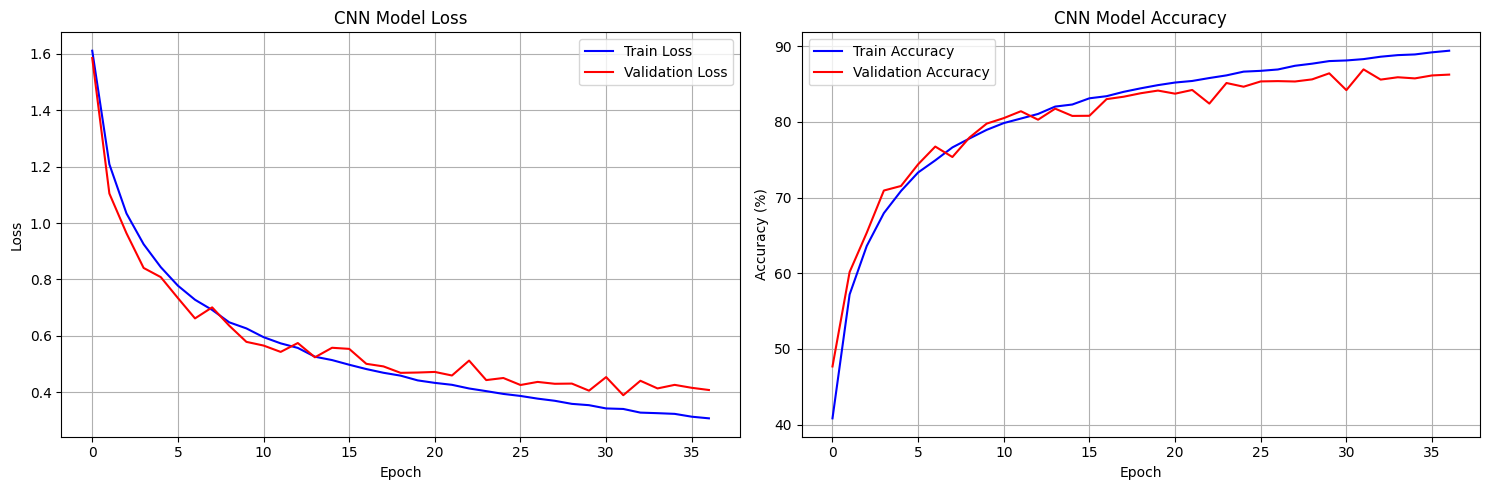


Modelo salvo como 'final_cnn_model.pth'

Número total de trials: 10
Trials completados: 6
Trials podados: 4


In [ ]:
def main():
    print("=== TREINAMENTO CNN CIFAR-10 COM OTIMIZAÇÕES ===\n")

    print("1. Preparando dados...")
    train_transform, test_transform = get_transforms()

    full_train_dataset = torchvision.datasets.CIFAR10(root='./data', train=True,
                                                      download=True, transform=train_transform)
    test_dataset = torchvision.datasets.CIFAR10(root='./data', train=False,
                                               download=True, transform=test_transform)

    # Dividir treino em treino e validação (80-20)
    train_size = int(0.8 * len(full_train_dataset))
    val_size = len(full_train_dataset) - train_size
    train_dataset, val_dataset = random_split(full_train_dataset, [train_size, val_size])

    print(f"Tamanhos dos conjuntos - Treino: {len(train_dataset)}, Validação: {len(val_dataset)}, Teste: {len(test_dataset)}")

    print("\n2. Otimizando hiperparâmetros com Optuna...")
    study = optuna.create_study(direction="maximize",
                               pruner=optuna.pruners.MedianPruner(n_startup_trials=5))

    study.optimize(objective, n_trials=10)

    print("\n=== MELHORES HIPERPARÂMETROS ===")
    for key, value in study.best_params.items():
        print(f"  {key}: {value}")
    print(f"  Melhor accuracy: {study.best_value:.4f}")

    best_params = study.best_params

    print("\n3. Treinamento final com melhores hiperparâmetros...")

    # Criar dataloaders finais
    train_loader = DataLoader(train_dataset, batch_size=best_params['batch_size'],
                             shuffle=True, num_workers=2)
    val_loader = DataLoader(val_dataset, batch_size=best_params['batch_size'],
                           shuffle=False, num_workers=2)
    test_loader = DataLoader(test_dataset, batch_size=best_params['batch_size'],
                            shuffle=False, num_workers=2)


    num_filters = [32, 64, 128]

    model = CNNRegularization(
        num_classes=10,
        num_filters=num_filters,
        kernel_sizes=[3, 3, 3],
        dropout_rate=best_params['dropout_rate'],
        use_batch_norm=best_params['use_batch_norm'],
        activation=best_params['activation']
    )

    print(f"Modelo criado: ResNet com {sum(p.numel() for p in model.parameters()):,} parâmetros")

    # Otimizador final
    if best_params['optimizer'] == "adam":
        optimizer = optim.Adam(model.parameters(), lr=best_params['lr'], weight_decay=1e-4)
    elif best_params['optimizer'] == "sgd":
        optimizer = optim.SGD(model.parameters(), lr=best_params['lr'],
                             momentum=0.9, weight_decay=1e-4)
    else:
        optimizer = optim.AdamW(model.parameters(), lr=best_params['lr'], weight_decay=1e-4)

    criterion = nn.CrossEntropyLoss()
    scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', patience=7, factor=0.5)

    # Treinamento final
    trainer = CNNTrainer(model, train_loader, val_loader, test_loader, device)
    trained_model = trainer.train(optimizer, criterion, scheduler, num_epochs=50, patience=5)

    print("\n4. Avaliação final no conjunto de teste...")
    final_scores = trainer.evaluate()

    print("\n=== RESULTADOS FINAIS CNN ===")
    for metric, score in final_scores.items():
        print(f"{metric.upper()}: {score:.4f}")

    print("\n5. Gerando gráficos de treinamento...")
    trainer.plot_training_history()

    return trained_model, trainer, study

if __name__ == "__main__":
    model, trainer, study = main()

    torch.save(model.state_dict(), 'final_cnn_model.pth')
    print("\nModelo salvo como 'final_cnn_model.pth'")

    print(f"\nNúmero total de trials: {len(study.trials)}")
    print(f"Trials completados: {len([t for t in study.trials if t.state == optuna.trial.TrialState.COMPLETE])}")
    print(f"Trials podados: {len([t for t in study.trials if t.state == optuna.trial.TrialState.PRUNED])}")

# Desempenho e Resultados com Optuna
Durante o processo de otimização com Optuna, foram realizados 10 trials, dos quais 6 foram completados com sucesso e 4 foram interrompidos automaticamente (pruned) por não apresentarem melhorias significativas durante o treinamento. **O baixo número de tentativas se deu pelo fato da limitação computacional que sofremos com o uso do Google Colab.**

O modelo final escolhido foi treinado por até 36 épocas, com early stopping ativado, interrompendo o treinamento quando a validação deixou de melhorar consistentemente. Ao longo do processo, observou-se um progresso constante nas métricas:

- Época 10: Val Acc = 80,51%

- Época 20: Val Acc = 83,74%

- Época 30: Val Acc = 84,21%

> Após o treinamento, o modelo foi avaliado no conjunto de teste final, obtendo os seguintes resultados:

# Métricas
1. Accuracy:	88,93%

2. Balanced Accuracy:	88,93%

3. Precision: 	89,02%

4. Recall:	88,93%

5. F1-Score:	88,95%

> Essas métricas indicam um desempenho consistente e bem balanceado entre as classes do CIFAR-10, demonstrando que o modelo treinado com CNN otimizada via Optuna foi eficaz na tarefa de classificação.

# Conclusão
> A utilização do Optuna foi fundamental para explorar automaticamente combinações eficientes de hiperparâmetros como taxa de aprendizado, batch size, dropout, ativação, otimizador e uso de batch normalization. Com isso, foi possível alcançar quase 89% de acurácia no teste, o que representa uma melhora significativa em relação a abordagens mais simples como MLPs. O modelo foi salvo como 'final_cnn_model.pth' e os gráficos de desempenho foram gerados ao final do processo.